#### NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 8 - Mini projects (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. Here, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [3]:
import sys
sys.path.append('./../')
!{sys.executable} -m pip install gdown h5py

In [1]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
#gdown.download(url, output, quiet=False, fuzzy=True)


### Load the data

In [2]:
path_to_data = '.' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [3]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


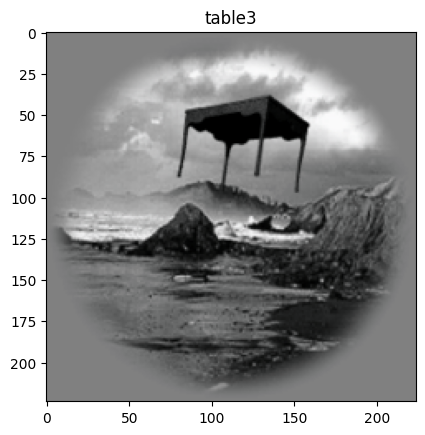

In [4]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

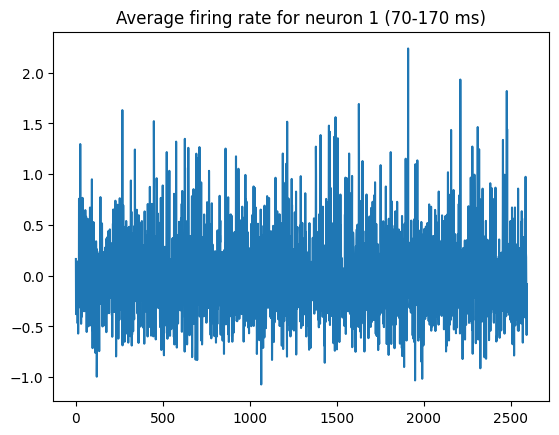

In [5]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

# Challenge: Develop the most accurate model for predicting IT neural activity.

Throughout the mini-projects, you have acquired knowledge on predicting neural activity through both task-driven and data-driven approaches. You are now free to explore both approaches to create the most effective model for predicting neural activity. Here are some suggestions to help guide your exploration:
- Optimize your current models by adjusting hyperparameters and implementing different regularizations.
- Utilize different pretrained models.
- Employ a pretrained neural network and finetune it for predicting the neural activity.
- Train a neural network for object recognition while simultaneously predicting neural activity.
- ...

Please note that all models will be tested using the same type of linear regression.

### EVALUATION

You have until midnight of 07/05/25 to submit your mini-projects. Please upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation, including figures and model comparisons.
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage. Please include instructions on loading the model and making neural predictions on the validation set. If necessary, include the checkpoint of your model in the .zip file.

Best of luck!

## Imports

In [6]:
#!pip install timm

In [7]:
# Basic libraries
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr

# For pre-trained Swin Transformer
import timm

## Best Neurons
Here we pick the best neurons to run our model on

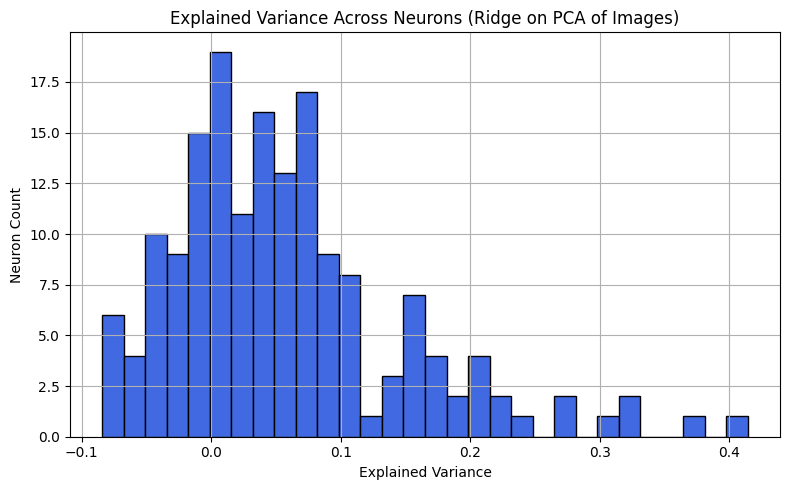

Top 5 Neuron EVs: [0.41410404443740845, 0.3776310086250305, 0.3196749687194824, 0.3151853084564209, 0.31279999017715454]
Mean EV across all neurons: 0.0573


In [8]:
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Flatten images
X_train_flat = stimulus_train.reshape(len(stimulus_train), -1)
X_val_flat = stimulus_val.reshape(len(stimulus_val), -1)

# Step 2: Apply PCA (reduce image dimensions)
pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)

# Step 3: Run Ridge regression for each neuron
ev_all = []
for i in range(spikes_train.shape[1]):
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_pca, spikes_train[:, i])
    preds = ridge.predict(X_val_pca)
    ev = explained_variance_score(spikes_val[:, i], preds)
    ev_all.append(ev)

# Step 4: Plot histogram of explained variances
plt.figure(figsize=(8, 5))
plt.hist(ev_all, bins=30, color='royalblue', edgecolor='black')
plt.title("Explained Variance Across Neurons (Ridge on PCA of Images)")
plt.xlabel("Explained Variance")
plt.ylabel("Neuron Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Print summary
print(f"Top 5 Neuron EVs: {sorted(ev_all, reverse=True)[:5]}")
print(f"Mean EV across all neurons: {np.mean(ev_all):.4f}")


In [9]:
# ev_all is the list of EVs for all 168 neurons
top_k = 20
top_neurons = np.argsort(ev_all)[-top_k:]  # top K neuron indices
print("Top neuron indices:", top_neurons)

spikes_train_top = spikes_train[:, top_neurons]
spikes_val_top = spikes_val[:, top_neurons]

Top neuron indices: [104 152   3 154 135 167 121 105 123  90 140 157 108 134  99  69 162 103
 101 141]


In [10]:
# Mean & std from ImageNet for pretrained Swin Transformer
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts (H, W, C) numpy → (C, H, W) tensor AND scales to [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

from PIL import Image

class NeuralDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # shape (3, 224, 224)
        target = self.targets[idx].astype(np.float32)

        # If shape is (C, H, W), transpose to (H, W, C)
        if img.shape[0] == 3 and img.ndim == 3:
            img = np.transpose(img, (1, 2, 0))  # Now (224, 224, 3)
        else:
            raise ValueError(f"Unexpected image shape at index {idx}: {img.shape}")

        img = img.astype(np.uint8)
        img = Image.fromarray(img, mode='RGB')

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(target)

In [11]:
batch_size = 32

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.tensor(stimulus_train).float(), torch.tensor(spikes_train_top).float())
val_dataset = TensorDataset(torch.tensor(stimulus_val).float(), torch.tensor(spikes_val_top).float())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

imgs, labels = next(iter(train_loader))
print(imgs.shape)  # should be [B, 3, 224, 224]
print(imgs.min(), imgs.max())  # should be around -2.1 to +2.6

torch.Size([32, 3, 224, 224])
tensor(-2.1179) tensor(2.6400)


In [20]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

# ResNet50 (CNN branch)
from torchvision.models import resnet50, ResNet50_Weights


class Swin_ResNet50_Hybrid(nn.Module):
    def __init__(self, hidden_dim=832, freeze_swin=True, freeze_cnn=True, top_k=20):
        super().__init__()

        # ResNet50 (CNN branch)
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.cnn_branch = nn.Sequential(*list(resnet.children())[:-6])  # (B, 2048, 7, 7)
        self.pool_cnn = nn.AdaptiveAvgPool2d((1, 1))  # (B, 512, 1, 1)
        self.output_scale = nn.Parameter(torch.tensor(1.0))  # add in model init

        if freeze_cnn:
            for p in self.cnn_branch.parameters():
                p.requires_grad = False


        # Swin Tiny (Transformer branch)
        self.swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=0)

        if freeze_swin:
            for p in self.swin.parameters():
                p.requires_grad = False
    

        self.decoder = nn.Sequential(
        nn.Linear(832, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, top_k)  # top 20 neurons
    )



    def forward(self, x):
        cnn_feats = self.cnn_branch(x)
        cnn_feats = self.pool_cnn(cnn_feats).flatten(1)

        swin_feats = self.swin(x)

        feats = torch.cat([cnn_feats, swin_feats], dim=1)
        x = self.decoder(feats)
        return self.output_scale * x

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.MSELoss()
# model = HybridResNetSwin().to(device)
model = Swin_ResNet50_Hybrid(freeze_cnn=False, freeze_swin=False).to(device)

print("Model loaded to:", device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

Model loaded to: cuda


In [14]:
# Utility: compute metrics
def compute_metrics(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    
    # Explained Variance, this is how we will judge the model against other models
    ev = explained_variance_score(y_true, y_pred, multioutput='raw_values')
    mean_ev = np.mean(ev)

    # Pearson Correlation (per neuron)
    correlations = []
    for i in range(y_true.shape[1]):
        try:
            corr = pearsonr(y_true[:, i], y_pred[:, i])[0]
            correlations.append(corr)
        except:
            correlations.append(np.nan)
    mean_corr = np.nanmean(correlations)
    rmse = np.sqrt(((y_pred - y_true) ** 2).mean())

    return mean_ev, mean_corr, rmse


In [15]:
def train(model, train_loader, val_loader, epochs=10):
    train_losses = []
    val_evs = []
    val_corrs = []
    val_rmses = []
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * imgs.size(0)


        train_loss /= len(train_loader.dataset)
        
        # Validation
        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device)
                preds = model(imgs)
                all_preds.append(preds)
                all_targets.append(targets)

        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        val_ev, val_corr, val_rmse = compute_metrics(all_targets, all_preds)
        train_losses.append(train_loss)
        val_evs.append(val_ev)
        val_corrs.append(val_corr)
        val_rmses.append(val_rmse)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val EV: {val_ev:.4f} | Val Corr: {val_corr:.4f}, | Val RMSE: {val_rmse:.4f}")
    plt.plot(val_evs, label = "EV")
    plt.plot(val_corrs, label = "Correlation")
    plt.plot(val_rmses, label = "validation RMS"); plt.title("Validation RMS, correlation, and EV");  plt.legend(); plt.show()

    return train_losses, val_evs, val_corrs, val_rmses, model

Epoch 1/100 | Train Loss: 0.1453 | Val EV: 0.3819 | Val Corr: 0.6289, | Val RMSE: 0.3292
Epoch 2/100 | Train Loss: 0.0977 | Val EV: 0.5210 | Val Corr: 0.7227, | Val RMSE: 0.2865
Epoch 3/100 | Train Loss: 0.0794 | Val EV: 0.5803 | Val Corr: 0.7619, | Val RMSE: 0.2629
Epoch 4/100 | Train Loss: 0.0694 | Val EV: 0.5957 | Val Corr: 0.7712, | Val RMSE: 0.2540
Epoch 5/100 | Train Loss: 0.0613 | Val EV: 0.6134 | Val Corr: 0.7841, | Val RMSE: 0.2522
Epoch 6/100 | Train Loss: 0.0559 | Val EV: 0.6249 | Val Corr: 0.7895, | Val RMSE: 0.2441
Epoch 7/100 | Train Loss: 0.0503 | Val EV: 0.6259 | Val Corr: 0.7964, | Val RMSE: 0.2439
Epoch 8/100 | Train Loss: 0.0462 | Val EV: 0.6409 | Val Corr: 0.7992, | Val RMSE: 0.2382
Epoch 9/100 | Train Loss: 0.0428 | Val EV: 0.6412 | Val Corr: 0.7995, | Val RMSE: 0.2377
Epoch 10/100 | Train Loss: 0.0400 | Val EV: 0.6403 | Val Corr: 0.8010, | Val RMSE: 0.2388
Epoch 11/100 | Train Loss: 0.0367 | Val EV: 0.6370 | Val Corr: 0.8006, | Val RMSE: 0.2395
Epoch 12/100 | Trai

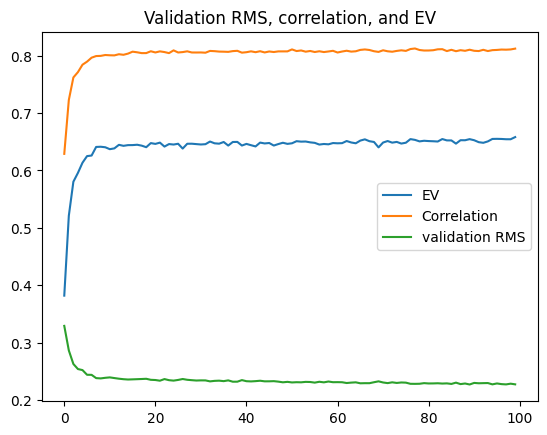

In [16]:
train_losses, val_evs, val_corrs, val_rmses, trained_model = train(model, train_loader, val_loader, epochs=100)

In [17]:
torch.save(model.state_dict(), "hybrid_model_top20.pth")

# store train_losses, val_evs, val_corrs, val_rmses
import pickle
with open('train_metrics_20.pkl', 'wb') as f:
    pickle.dump((train_losses, val_evs, val_corrs, val_rmses), f)

Model loaded to: cuda
Epoch 1/100 | Train Loss: 0.1322 | Val EV: 0.0982 | Val Corr: 0.3054, | Val RMSE: 0.3520
Epoch 2/100 | Train Loss: 0.1124 | Val EV: 0.2255 | Val Corr: 0.4724, | Val RMSE: 0.3197
Epoch 3/100 | Train Loss: 0.0962 | Val EV: 0.3014 | Val Corr: 0.5373, | Val RMSE: 0.2990
Epoch 4/100 | Train Loss: 0.0868 | Val EV: 0.3329 | Val Corr: 0.5638, | Val RMSE: 0.2888
Epoch 5/100 | Train Loss: 0.0810 | Val EV: 0.3631 | Val Corr: 0.5893, | Val RMSE: 0.2815
Epoch 6/100 | Train Loss: 0.0763 | Val EV: 0.3811 | Val Corr: 0.6036, | Val RMSE: 0.2762
Epoch 7/100 | Train Loss: 0.0722 | Val EV: 0.3963 | Val Corr: 0.6154, | Val RMSE: 0.2714
Epoch 8/100 | Train Loss: 0.0688 | Val EV: 0.4076 | Val Corr: 0.6243, | Val RMSE: 0.2675
Epoch 9/100 | Train Loss: 0.0661 | Val EV: 0.4093 | Val Corr: 0.6262, | Val RMSE: 0.2677
Epoch 10/100 | Train Loss: 0.0637 | Val EV: 0.4238 | Val Corr: 0.6366, | Val RMSE: 0.2629
Epoch 11/100 | Train Loss: 0.0612 | Val EV: 0.4285 | Val Corr: 0.6408, | Val RMSE: 0.26

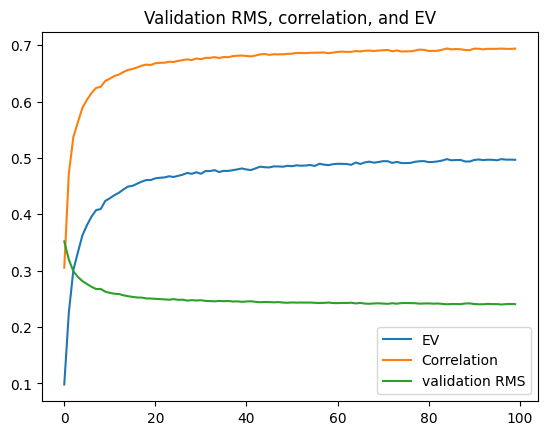

In [21]:
batch_size = 32

train_dataset_full = TensorDataset(torch.tensor(stimulus_train).float(), torch.tensor(spikes_train).float())
val_dataset_full = TensorDataset(torch.tensor(stimulus_val).float(), torch.tensor(spikes_val).float())

train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader_full   = DataLoader(val_dataset_full, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.MSELoss()
# model = HybridResNetSwin().to(device)
model_full = Swin_ResNet50_Hybrid(freeze_cnn=False, freeze_swin=False, top_k=168).to(device)

print("Model loaded to:", device)

# Optimizer
optimizer = torch.optim.AdamW(model_full.parameters(), lr=5e-5, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

train_losses_full, val_evs_full, val_corrs_full, val_rmses_full, trained_model_full = train(model_full, train_loader_full, val_loader_full, epochs=100)

In [22]:
torch.save(model_full.state_dict(), "hybrid_model_full_neurons.pth")

# store train_losses, val_evs, val_corrs, val_rmses
import pickle
with open('train_metrics_full.pkl', 'wb') as f:
    pickle.dump((train_losses_full, val_evs_full, val_corrs_full, val_rmses_full), f)

In [ ]:
# Same architecture
model = Swin_ResNet50_Hybrid(freeze_cnn=False, freeze_swin=False).to(device)

# Adjust final layer to output 20 neurons (or however many you're targeting)
model.decoder[-1] = nn.Linear(model.decoder[-1].in_features, 168)  # take all 168 neurons

# Load weights
# model.load_state_dict(torch.load("hybrid_model_top20.pth"))
model.load_state_dict(torch.load("hybrid_model_full_neurons.pth"))
model.eval()

# Reuse saved top neuron indices
# top_k = 20
# ev_all is the list of EVs for all 168 neurons using the PCA we had earlier
#   Top neuron indices: [  3 152 104 135 154 167 123 121 105  90 140 157 108 134  99 162  69 103 101 141]
# top_indices = np.argsort(ev_all)[-top_k:]

In [ ]:
from test_predictions import predict_stimulus

predict_stimulus(stimulus_test, "hybrid_model_full_neurons.pth",out_dims = 168)
